# Task 2 and 3

## Investigating Earthquakes in Hawaii between 2014 and 2023

**Faith Whyte** - *This project is for educational purposes only.*

According to the [USGS](https://www.usgs.gov/observatories/hvo/science/about-earthquakes-hawaii#:~:text=The%20earthquake%20record%20since%201823,one%20M5%20or%20greater%20earthquake.), thousands of earthquakes occur every year in Hawaii, some of which are destructive. The aim of this project is to investigate earthquakes felt by people in Hawaii over the course of a decade. 

This will be acheived by retrieving data from the [USGS Earthquake Catalog API](https://earthquake.usgs.gov/fdsnws/event/1/) under specific conditions, engineering the raw data, performing exploratory analysis, visualising the results, and extracting insights about earthquakes in Hawaii between 2014 and 2023.


The scope of this project limits the collection of data to events with positive 'felt' values, indicating that at least one person has subitted a record through the [*Did You Feel It?*](https://earthquake.usgs.gov/data/dyfi/) system. Geographic coordinates (21.3099°, -157.8581°) denote the midpoint of Hawaii. This midpoint along with a search radius of 1,250km filters the data to earthquakes events across all islands of Hawaii.

This Jupyter Notebook is the second of two for this project and encompasses the data cleaning, analysis and visualisation as well as a discussion of findings. 

## Housekeeping

### Importing the necessary libraries 

In [1]:
# File management:

from pathlib import Path
import os

# JSON management:

import json 

# Dataframe management:

import pandas as pd

# Managing temporal data: 

import datetime
import calendar

# Plotting and graphing: 

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# For calculating k means and euclidean distances:

#pip install sklearn # Install library if necessary.

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# To access a basemap:

#pip install geopandas # Install GeoPandas and its dependencies if necessary.
import geopandas as gpd

# Array management:

import numpy as np

### Set the working directory

In [2]:
# Assign the path to "Earthquake Project" to wd.

wd = Path("Earthquake Project")

# Set wd as the working directory.

os.chdir(wd)

print("Working directory is set. The base folder is: %s." % os.path.basename(os.getcwd()))

Working directory is set. The base folder is: Earthquake Project.


### Loading the dataset

Using the read_pickle function, the dataset that was created in **Task 1** is loaded into this notebook. The code below will produce a message to signify if the dataset can be loaded. If the dataset loads successfully, the total number of entries will be displayed and the first 3 entries will be presented. 

In [3]:
try: 
    df = pd.read_pickle("Earthquake Dataset")
    print("The data is accessible. There are %d entries in the dataset. Here are the first 3:" % len(df))
    df_head = df.head(3)

except:
    df_head = print("The data is inaccessible. There is nothing to display.")
    
df_head # The output will depend on whether the data loaded successfully or not.

The data is accessible. There are 4507 entries in the dataset. Here are the first 3:


,Id,Data type,Coordinates,Geometry type,Alert,Cdi,Detail,Dmin,Felt,Gap,...,Sources,Status,Time,Title,Tsunami,Seismic type,Types,Tz,Updated,Url
Code,,,,,,,,,,,,,,,,,,,,,
73704697,hv73704697,Feature,"[-155.246666666667, 19.3865, 1.35]",Point,None,2.7,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,10,45.0,...,",hv,us,",reviewed,1704012869020,"M 2.9 - 6 km SSW of Volcano, Hawaii",0,earthquake,",dyfi,origin,phase-data,",None,1709415574040,https://earthquake.usgs.gov/earthquakes/eventp...
73704627,hv73704627,Feature,"[-155.503666666667, 20.0086666666667, 13.04]",Point,None,2.7,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,3,157.0,...,",us,hv,",reviewed,1704008857340,"M 2.4 - 8 km SSW of Honoka‘a, Hawaii",0,earthquake,",dyfi,origin,phase-data,",None,1709415574040,https://earthquake.usgs.gov/earthquakes/eventp...
73700837,hv73700837,Feature,"[-155.460833333333, 19.1943333333333, 31.4]",Point,None,2.2,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,1,146.0,...,",hv,us,",reviewed,1703895268370,"M 2.5 - 2 km ESE of Pāhala, Hawaii",0,earthquake,",dyfi,origin,phase-data,",None,1709415573040,https://earthquake.usgs.gov/earthquakes/eventp...


## Task 2: Data Preparation

### Removing other seismic event data

The USGS Earthquake Catalog contains entries from other seismic activies. Entries that are for events other than earthquakes are removed from the dataset.

In [4]:
df = df[df["Seismic type"] == "earthquake"] # Rewrites the dataframe to only contain earthquake entries.

print("There are %d earthquake records." % len(df)) # Prints the new number of entries.

There are 4449 earthquake records.


### Creating the time variables: 'Month', 'Year' and 'Season'

The time each earthquake occured is recorded in milliseconds since the epoch which must first be converted to UTC. The month and year can then be extracted.

In [5]:
# Define a function that determines the year from a timestamp.

def year(timestamp):
    timestamp_seconds = timestamp/1000
    year = datetime.datetime.utcfromtimestamp(timestamp_seconds).strftime('%Y')
    return year

# Create a new variable "Year".

df["Year"] = df["Time"].apply(year)

# Define a function that determines the month from a timestamp.

def month(timestamp):
    timestamp_seconds = timestamp/1000
    month = datetime.datetime.utcfromtimestamp(timestamp_seconds).strftime('%m')
    return month

# Create a new variable "Month".

df["Month"] = df["Time"].apply(month)

Using the new variable "Month", the earthquakes can be classified by the meterological season in which they occured.

In [6]:
# Define the conditions for each season.

season_months = [(df["Month"] == "03") | (df["Month"] == "04") | (df["Month"] == "05"),
                 (df["Month"] == "06") | (df["Month"] == "07") | (df["Month"] == "08"), 
                 (df["Month"] == "09") | (df["Month"] == "10") | (df["Month"] == "11"),
                 (df["Month"] == "12") | (df["Month"] == "01") | (df["Month"] == "02")]

# Define the name of each season.

seasons = ["Spring", "Summer", "Autumn", "Winter"]

# Assign the season names.

df["Season"] = np.select(season_months, seasons, default = "unknown")

# Check that there are no "unknown" entries.

if not df["Season"].unique().any() == ["unknown"]:
    print("Seasons have been successfully assigned.")

Seasons have been successfully assigned.


### Removing invalid columns from the dataframe

The dataset will be filtered to contain only complete columns.

In [7]:
# Define a function that returns a 0 if the input is 0, else it returns a ratio of the input to the length of the dataframe.

def ratio_na(x):
    if x == 0:
        return 0
    else:
        return round(x/(len(df)), 5) # Round the results to five decimel places.
    
# Apply the function to the sum of the NaN values for each column, to determine the ratio of null to valid cells per column.

result = df.isnull().sum().apply(ratio_na)

# Filter the dataframe to remove all columns that contain only empty cells.

df = df.loc[:, result != 1]

### Extracting cooridinate and depth data

The georaphical coordinates and depth information for each earthquake event is recorded in list format in one column *Coordinates*. These will be separated and held in a new dataframe.

In [8]:
# Create a loop that iterates over the coordinate data, creating dictionaries for each row.
# These dictionaries are then appended to a list of coordinates.

coords = []

for i, row in df.iterrows():
    coord = row["Coordinates"]
    coord_dict = {"Longitude (°)":coord[0], "Latitude (°)":coord[1], "Depth (km)":coord[2]}
    coords.append(coord_dict)
    
# Create a data frame from the list of cooridinates that uses the same index "Code" as the original data frame.

df_coord = pd.DataFrame(coords)
df_coord.index = df.index

# Visualise the first 5 entries of the new coordinates dataframe.

print("First five entries of the coordinates dataset:")
df_coord.head(5)

First five entries of the coordinates dataset:


,Longitude (°),Latitude (°),Depth (km)
Code,,,
73704697,-155.246667,19.386500,1.35
73704627,-155.503667,20.008667,13.04
73700837,-155.460833,19.194333,31.40
73700682,-155.747000,20.008167,6.77
73700537,-155.285995,19.412001,1.21


The coordinate data is then added to the main dataset for later analysis. 

In [9]:
# Add the columns from the coordinate dataframe to the main dataframe.

df = pd.concat([df, df_coord], axis=1).reindex(df.index)

### Tidying Source Information

The *Sources* column contains strings of comma separated lists of network contributors. This information cannot be assessed in this form so they must be split into separate columns.

In [10]:
# Separate the string into a list of strings based on the commas.

df["Sources"] = df["Sources"].str.split(",")

# Create a loop that iterates over the source data, creating dictionaries for each row.
# These dictionaries are then appended to a list of sources.

sources = []

for i, row in df.iterrows():
    source = row["Sources"]
    source_dict = {"Source %s" % (i+1): pos for i, pos in enumerate(source)}
    sources.append(source_dict)

# A new dataframe containing the source information is created.    
    
df_source = pd.DataFrame(sources)
df_source.index = df.index

The original formatting of the source information caused some empty cells in the new dataframe. Any empty cell will be assigned a NaN value so that columns containing no values can be removed.

In [11]:
# Assign NaN value to empty cells.

df_source = df_source.replace("", np.nan)

# Define a function that returns a 0 if the input is 0, else it returns a ratio of the input to the length of the dataframe.

def ratio_source_na(x):
    if x == 0:
        return 0
    else:
        return round(x/(len(df_source)), 5)# Round the results to five decimel places.
    
    
    

# Apply the function to the sum of the NaN values for each column, to determine the ratio of null to valid cells per column.

result = df_source.isnull().sum().apply(ratio_source_na)

# Filter the dataframe to remove all columns that contain only empty cells.

df_source = df_source.loc[:, result != 1]

# Check which columns remain by viewing the first 3 data entries in the source dataframe.

df_source.head(3)

,Source 2,Source 3,Source 4,Source 5,Source 6
Code,,,,,
73704697,hv,us,NaN,NaN,NaN
73704627,us,hv,NaN,NaN,NaN
73700837,hv,us,NaN,NaN,NaN


Since there is no *Source 1*, the columns are renamed appropriately.

In [12]:
# Rename the columns appropriately.

df_source.rename(columns = {"Source 2" : "Source 1", 
                     "Source 3" : "Source 2",
                     "Source 4" : "Source 3",
                     "Source 5" : "Source 4",
                     "Source 6" : "Source 5"},
          inplace = True)

# Capitalise all the entries as they are acronyms for the data contributors. 

df_source = df_source.applymap(lambda source: source.upper() if type(source) == str else source)

# View the first 3 data entries.

df_source.head(3)


,Source 1,Source 2,Source 3,Source 4,Source 5
Code,,,,,
73704697,HV,US,NaN,NaN,NaN
73704627,US,HV,NaN,NaN,NaN
73700837,HV,US,NaN,NaN,NaN


The source dataframe is better formatted now. It can be called later for analysis.

### Assessing the usefulness of variables

Some of the information included in the dataset will not provide useful insights. 
The number of unique values in a column can be indicative of its usefulness. The variables *Alerts* and *Tsunami* will be examined as they appear to lack variety from initial inspection of the dataset.

In [13]:
# Aggregate data by Alert variable, and find counts for each unique value.

df.groupby("Alert").size()

Alert
green     148
yellow      1
dtype: int64

In [14]:
# Aggregate data by the Tsunami variable, and find counts for each unique value.

df.groupby("Tsunami").size()

Tsunami
0    4448
1       1
dtype: int64

Both of these variables will provide little information during the analyses. They will be removed from the dataset.

### Removing variables

It will not be possible to analyse every variale in the earthquake dataset. In addition to those mentioned above, some columns will be removed to avoid data redunancy and to make the dataframe more manageable.

In [15]:
# Drop unwanted columns from the data frame. 

df.drop(columns=["Sources", "Coordinates", "Time", 
                 "Place", "Gap", "Updated", "Mmi",
                 "Gap", "Dmin", "Ids", "Id", "Url",
                 "Geometry type", "Detail", "Alert",
                 "Seismic type", "Tsunami", "Types",
                 "Data type", "Rms", "Cdi"], inplace = True, axis = 1)

In [16]:
# Check which columns remain.

print("The dataframe now contains the following variables:")
for col_names in df.columns:
    print("- %s" % col_names)

The dataframe now contains the following variables:
- Felt
- Mag
- Magtype
- Net
- Nst
- Sig
- Status
- Title
- Year
- Month
- Season
- Longitude (°)
- Latitude (°)
- Depth (km)


In [17]:
# Remove any potential duplicate rows

df = df.drop_duplicates()

# Check if any rows contain only empty cells

print("There are %d rows with only empty cells. %s entries remain in the dataframe." % (sum(df.isnull().all(axis = 1)), len(df)))

There are 0 rows with only empty cells. 4449 entries remain in the dataframe.


There were no duplicated rows or rows containing only empty cells so the number of data entries remains the same.

In [18]:
# View the first 5 entries of the cleaned dataframe to observe the new columns.

df.head(5)

,Felt,Mag,Magtype,Net,Nst,Sig,Status,Title,Year,Month,Season,Longitude (°),Latitude (°),Depth (km)
Code,,,,,,,,,,,,,,
73704697,10,2.89,ml,hv,47.0,131,reviewed,"M 2.9 - 6 km SSW of Volcano, Hawaii",2023,12,Winter,-155.246667,19.386500,1.35
73704627,3,2.44,md,hv,36.0,92,reviewed,"M 2.4 - 8 km SSW of Honoka‘a, Hawaii",2023,12,Winter,-155.503667,20.008667,13.04
73700837,1,2.54,ml,hv,60.0,99,reviewed,"M 2.5 - 2 km ESE of Pāhala, Hawaii",2023,12,Winter,-155.460833,19.194333,31.40
73700682,3,2.37,ml,hv,31.0,87,reviewed,"M 2.4 - 7 km WSW of Waimea, Hawaii",2023,12,Winter,-155.747000,20.008167,6.77
73700537,1,2.24,ml,hv,30.0,77,automatic,"M 2.2 - 6 km WSW of Volcano, Hawaii",2023,12,Winter,-155.285995,19.412001,1.21


The dataset seems much more manageable now and still contains sufficient data for analysis.

## Task 2: Data Analysis

### Analysis of sources

The variable *Sources* differs from the *Net* variable in that it lists all network contributors for an event, whereas *Net* is the preferred network contributor for the an event. Data transparency is very important to ensure its integrity, so it is always good practice to examine the sources.

In [19]:
# Determine the number of times each network contributor contributed to the dataset by counting each occurance.

count_sources = pd.DataFrame(df_source.stack().value_counts())

# Create a table to display the counts. 

count_sources.rename(columns = {"count":"Number of entries"}, inplace=True) 

# View the number of entries per each network contributor. 

print("Network contributor appearances as a source in the dataset:")
count_sources.transpose()

Network contributor appearances as a source in the dataset:


,HV,US,PT,AT,ISCGEM,ATLAS
Number of entries,4475,3042,91,4,2,1


Thee Hawaii Volcano Observatory (HV) and the USGS National Earthquake Information Centre (US) provided the most information in the cleaned dataset. Together they contributed 7,517 times, while the others contributed a total of 98 time.

### Summary statistics and visualising the distribution of numerical data

In [20]:
df_stats = pd.DataFrame(df.describe()) # Create a table containing summary statistics of the numeric data 

# Remove Year, Month and Long/Lat coordinates from the summary statistics as they may lead to misinterpretation. 

df_stats.drop(["Longitude (°)","Latitude (°)"], axis = 1, inplace = True)

# View the summary statistics.

print("Summary statistics of numerical data:")
df_stats

Summary statistics of numerical data:


,Felt,Mag,Nst,Sig,Depth (km)
count,4449.000000,4449.000000,4432.000000,4449.000000,4449.000000
mean,14.111486,2.697991,35.267599,123.959991,11.891053
std,103.840206,0.665681,15.561503,81.421376,14.529781
min,1.000000,0.170000,0.000000,1.000000,-3.740000
25%,1.000000,2.250000,23.000000,78.000000,0.540000
50%,1.000000,2.700000,35.000000,113.000000,2.890000
75%,4.000000,3.140000,49.000000,153.000000,30.750000
max,3487.000000,6.900000,82.000000,1392.000000,72.220001


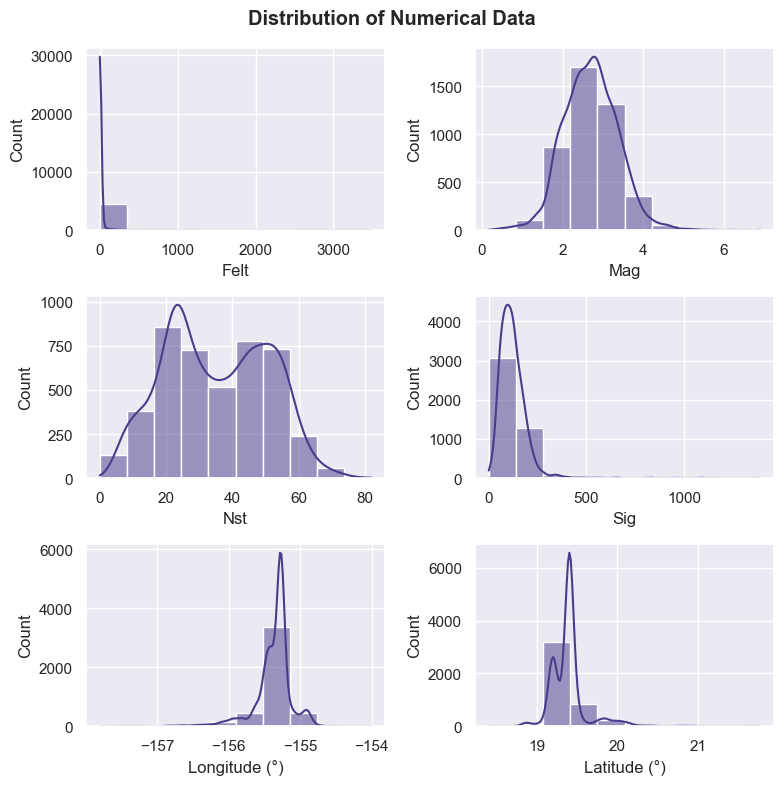

In [21]:
# Create a dataframe containing only numerical data.

df_numeric = df.select_dtypes(include = "number")

# Set up aesthetics.

sns.set()
sns.set_style("darkgrid")

# Create a figure 

plt.figure(figsize=(8, 8))
plt.suptitle("Distribution of Numerical Data", fontweight = "bold")


# Create a loop that through the column indices to create histograms and denstiny lines to show the distribution of data.


for i in range(0,6):
    plt.subplot(3,2, i + 1) 
    sns.histplot(data=df[df_numeric.columns[i]], fill = True, color = "darkslateblue", bins = 10, kde = True)  
    plt.xlabel(df_numeric.columns[i])
    

plt.tight_layout()
plt.show()

The distribution of felt records and significance values are right-skewed, indicating most records lie on the lower end of the scale. Depth and total number of stations used to determine earthquake location (*Nst*) both have bimodal distribution. Magnitude at first appears to be normally distributed, though the data appears is skewed because of one outlier event with a magnitude of 6.9. 

### Summary statistics and visualising the distribution of categorical data

In [22]:
# Create a dataframe containing only categorical data.

df_categorical = df.select_dtypes(include=['object', 'category'])

# View the categorical dataframe.

print("Firt 5 rows of the categorical data:")
df_categorical.head(5)

Firt 5 rows of the categorical data:


,Magtype,Net,Status,Title,Year,Month,Season
Code,,,,,,,
73704697,ml,hv,reviewed,"M 2.9 - 6 km SSW of Volcano, Hawaii",2023,12,Winter
73704627,md,hv,reviewed,"M 2.4 - 8 km SSW of Honoka‘a, Hawaii",2023,12,Winter
73700837,ml,hv,reviewed,"M 2.5 - 2 km ESE of Pāhala, Hawaii",2023,12,Winter
73700682,ml,hv,reviewed,"M 2.4 - 7 km WSW of Waimea, Hawaii",2023,12,Winter
73700537,ml,hv,automatic,"M 2.2 - 6 km WSW of Volcano, Hawaii",2023,12,Winter


In [23]:
# Create the summary statistics of the categorical data. 

df_cat_stats = df_categorical.describe()

# Assign top_perc which calculates the top value's frequency as a percentage.

top_perc = (100*(df_categorical == df_categorical.mode().iloc[0]).sum()/len(df)).round(2)

# Create a dataframe row, top_perc and rename it.

top_perc_df = pd.DataFrame(top_perc)
top_perc_df.rename(columns = {0 : "Top value % frequency"}, inplace = True)

# Merge the new row to the summary statistics (categorical) table.

df_cat_stats = pd.concat([df_cat_stats, top_perc_df.transpose()], axis = 0)

print("Summary statistics of categorical data:")
df_cat_stats


Summary statistics of categorical data:


,Magtype,Net,Status,Title,Year,Month,Season
count,4449,4449,4449,4449,4449,4449,4449
unique,4,2,2,2558,10,12,4
top,ml,hv,reviewed,"M 2.7 - 5 km SW of Volcano, Hawaii",2018,07,Summer
freq,3516,4433,3517,37,1949,915,1998
Top value % frequency,79.03,99.64,79.05,0.83,43.81,20.57,44.91


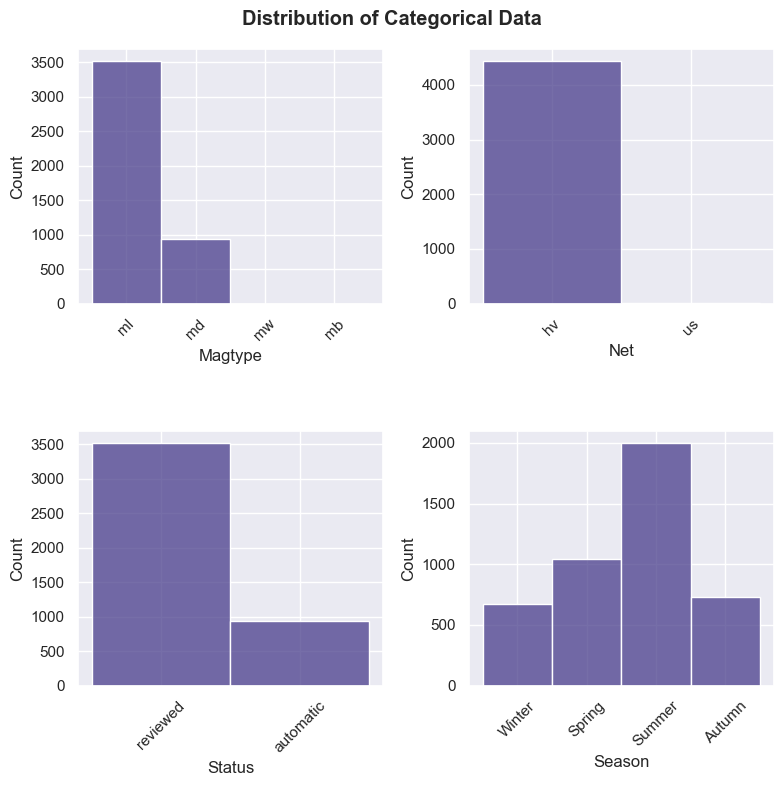

In [24]:
# Sort data by date. 

df_categorical.sort_values(["Month", "Year"], ascending=[True, True], inplace = True)

# Create figure.

plt.figure(figsize=(8, 8))
plt.suptitle("Distribution of Categorical Data", fontweight = "bold")

# Iterate through the columns to create histograms to visualise the distribution of categorical data in the dataset.

for i in range(0,4):
    plt.subplot(2,2, i + 1) 
    sns.histplot(data=df_categorical[df_categorical.drop(columns = ["Title", "Month", "Year"]).columns[i]], fill = True, color = "darkslateblue", bins = 10) # Drop title as there are too many unique values to deliver meaningful findings
    plt.xlabel(df_categorical.drop(columns = ["Title", "Month", "Year"]).columns[i]) # Drop year and month as plots will be drawn later
    plt.xticks(rotation = 45)
    
plt.tight_layout()
plt.subplots_adjust(hspace = 0.5) # Add extra space between row of plots.
plt.show()

[*Magtype*](https://www.usgs.gov/programs/earthquake-hazards/magnitude-types) refers to the method of recording magnitude and varies depending on magnitude size. It makes sense that most recordings used *ML* or *MD* as most events had a magnitude below 3. The preferred network contributor (*Net*) for most events was the Hawaiian Volcano Observatory (*HV*). The majority of the data records were manually reviewed. Summer months contained the highest number of reported earthquakes.

### Visualising the relationship between variables

A pairplot allows for visualising the pairwaise relationship between the numerical values in the dataset. The diagonal displays the distribution of each variable.  

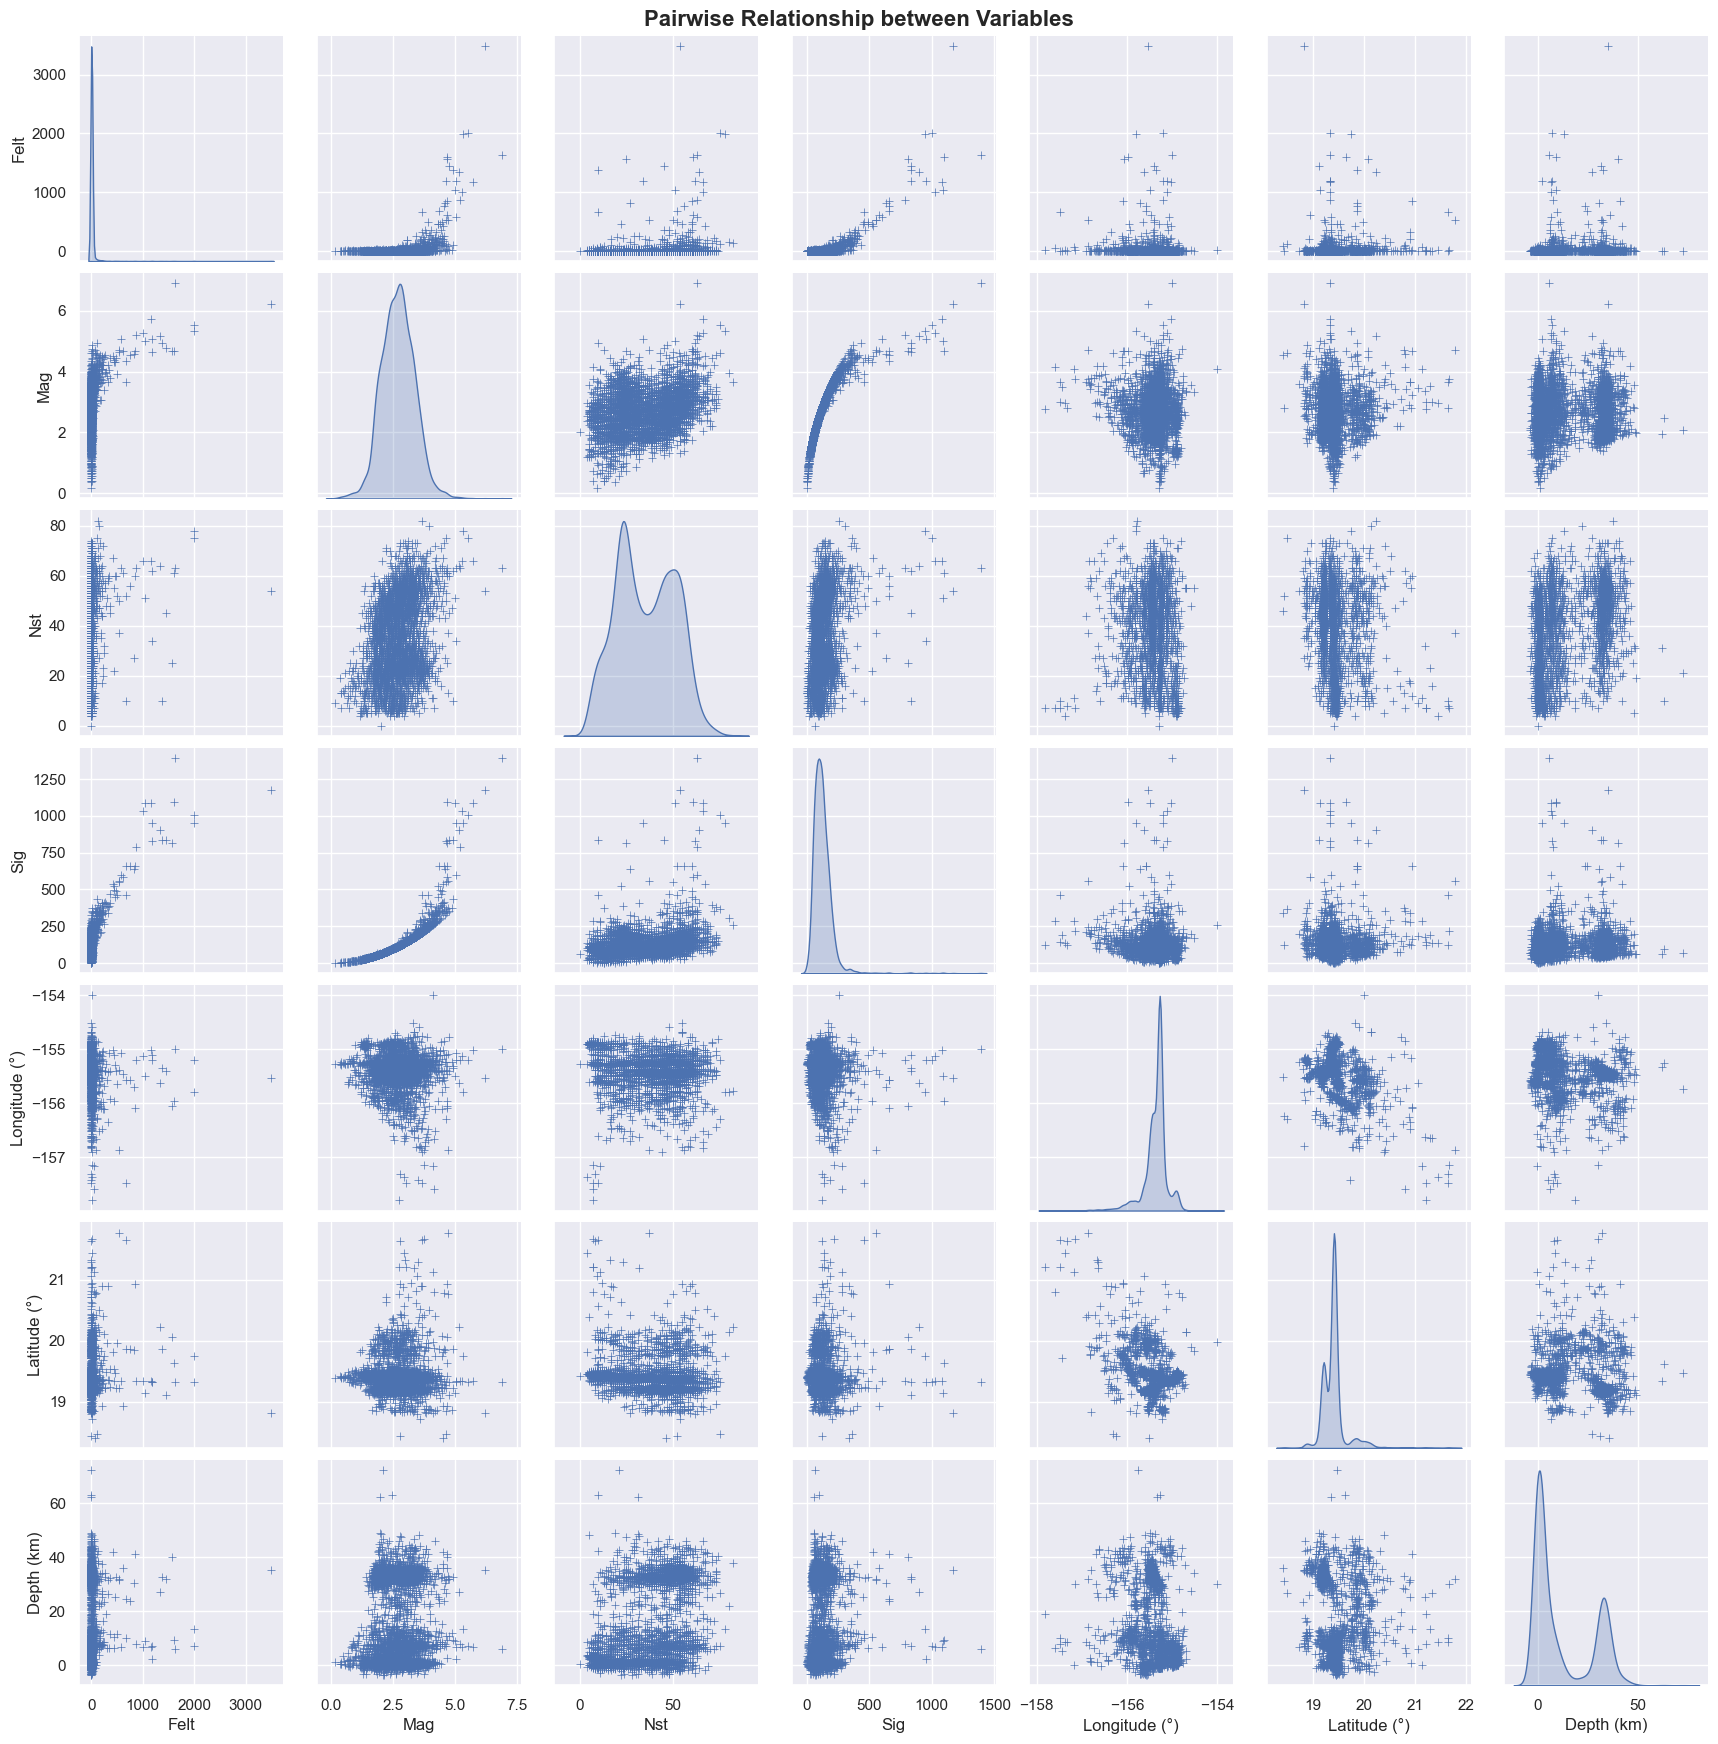

In [25]:
sns.pairplot(df, diag_kind = "kde", plot_kws = dict(marker = "+", linewidth = 0.5))

plt.suptitle("Pairwise Relationship between Variables", fontweight = "bold", fontsize = 16, y = 1.0)

plt.show()

The variable *Sig* seems to be positively related to *Felt* and *Mag*, though the nature of this relationship requires further analysis.

### Determing correlation between variables

The Pearson correlation coefficient can be computed and plotted on a heatmap to show the correlation between numerical variables.

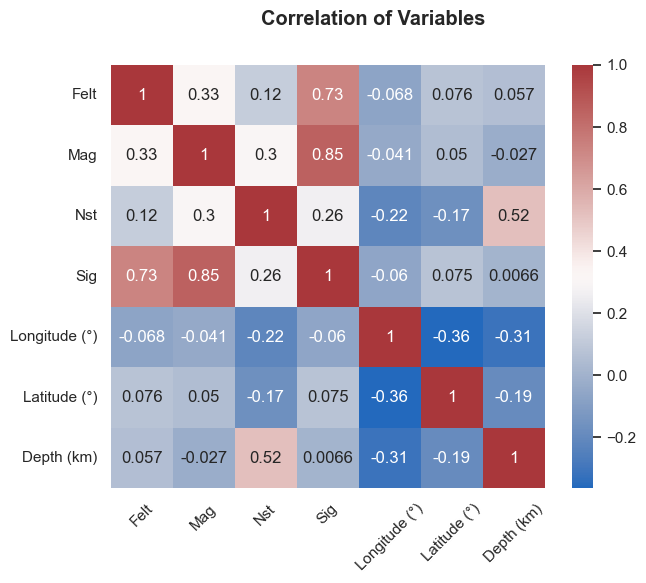

In [26]:
# Create the figure.

plt.figure(figsize=(7, 5.5))
plt.suptitle("Correlation of Variables", fontweight = "bold")

# Compute correlation coefficients.

corr_coef = df_numeric.corr()

# Plot the correlations in a pairwise matrix.

sns.heatmap(corr_coef, cmap = "vlag", annot=True) 
plt.xticks(rotation = 45)

plt.show()

This heatmap suggests strong positive correlation between the significance and magnitude of an earthquake event (*Pearson's coefficient* = 0.73). The significance is also strongly positively correlated with the number of felt reports (*Pearson's coefficient* = 0.85). This was expected as significance is an index that in based on a number of factors including magnitude and felt reporting. More information can be seen in the catalogue's [documentation](https://earthquake.usgs.gov/data/comcat/#sig). There is a moderate positive correlation between the total number of seismic stations used to determine earthquake location (Nst) and the depth of an earthquake (*Pearson's coefficient* = 0.52), though there is no indication of any cause for this correlation.

### Visualising the temporal patterns of data

Lineplots can be used to visualise trends in data over time. Monthly variations to mean number of felt reports, earthquake magnitude, significance and depth will be plotted. 

In [27]:
# Convert month column to numeric.

df['Month'] = pd.to_numeric(df['Month'] )

# Apply month abbreviations to each month.

df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])

# Order the data by month of the year, not alphabetically.

months = calendar.month_abbr[1:13]

df['Month'] = pd.Categorical(df['Month'], categories = months, ordered = True)

In [28]:
df = df.sort_values('Month') 

# Group the data by month 

month_group = df.set_index("Month").select_dtypes(include = "number").groupby("Month")

# Group the data by year

year_group = df.set_index("Year").select_dtypes(include = "number").groupby("Year") # Setting index and selecting numerical only allows for calculation of mean values.

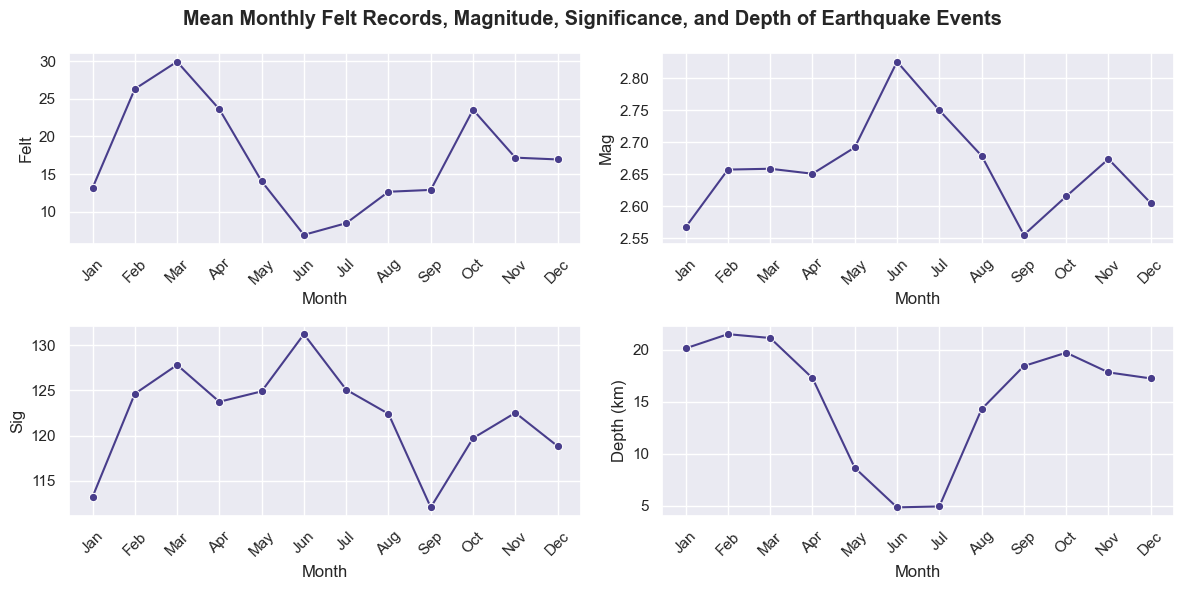

In [29]:
# Set figure aesthetics and arrangement.

plt.figure(figsize=(12,6))
sns.set_style("darkgrid")
plt.suptitle("Mean Monthly Felt Records, Magnitude, Significance, and Depth of Earthquake Events", fontweight = "bold")

# Assign variable to the mean values in the month group

data = month_group.mean().drop(columns= ["Nst", "Longitude (°)", "Latitude (°)"]) # Drop meaningless columns

# Iterate over columns of data to create multiple plots

for i, col in enumerate(data):
    plt.subplot(2, 2, i + 1) 
    sns.lineplot(data = data, y = col, x = data.index, marker = "o", color = "darkslateblue")
    plt.xticks(rotation=45)
    

plt.tight_layout()
plt.show()

These plots provide insights into monthly variations of felt records, earthquake depth, magnitude and significance. Despite the positive correlation between felt records and significance, as uncovered by the correlation analysis of variables, June had the lowest mean number of felt records despite experiencing the highest mean event significance and magnitude. 

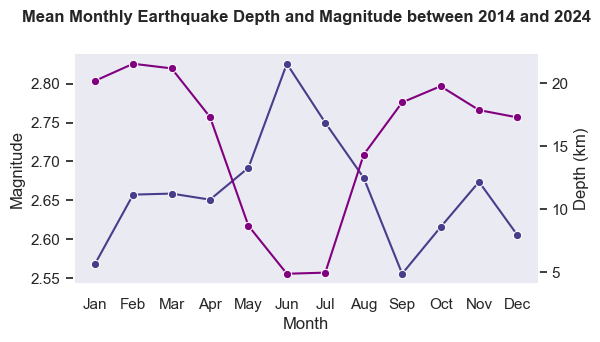

In [30]:
# Set figure aesthetic and arrangement.

plt.figure(figsize=(6,3))
sns.set_style("dark") # Remove grid from styling.


# Using same data as previous plots, plot mean monthly magnitude.

ax = sns.lineplot(data=data, x="Month", y="Mag", color = "darkslateblue",  marker = "o")

ax2 = ax.twinx() # Puts a second plot on same x axis as first.

# Plot mean monthly depth. 

ax2 = sns.lineplot(data=data, x="Month", y="Depth (km)", ax = ax2, color = "purple",  marker = "o")

ax.set_ylabel("Magnitude") # y label for first plot.
ax2.set_ylabel("Depth (km)") # y lable for second plot.

plt.title("Mean Monthly Earthquake Depth and Magnitude between 2014 and 2024", fontweight = "bold", y = 1.1)

plt.show()

Although the correlation statistic in the heatmap did not show a strong negative correlation between earthquake depth and magnitude, plotting mean monthly values for depth and magnitude suggests there may be some relationship that the Pearson's correlation failed to detect. It seems as if the closer the earthquake is the the surface, the stronger the magnitude recording. Further analysis of correlation is necessary to make any conclusions.  

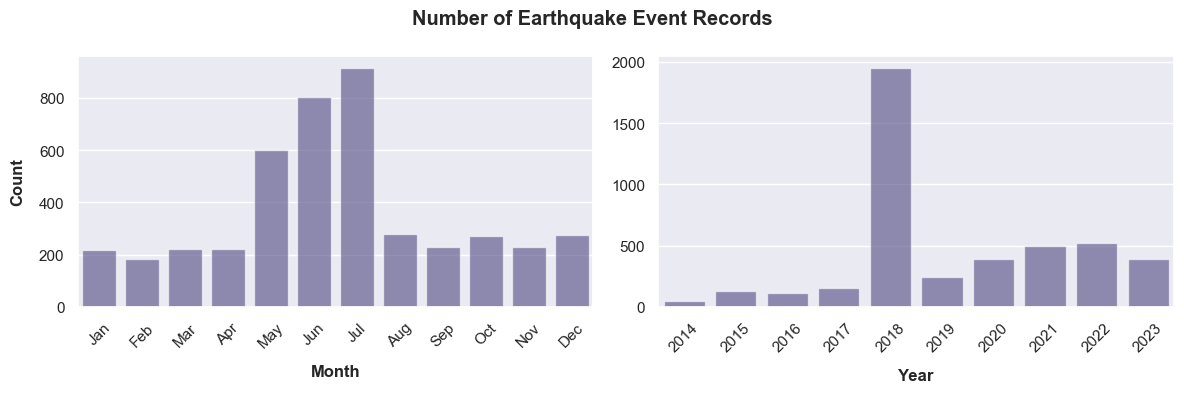

In [31]:
# Set figure aesthetic and arrangement.

sns.set_style("darkgrid") 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))
plt.suptitle("Number of Earthquake Event Records", fontweight = "bold")

# Create first barplot of counts per month.

bp1 = sns.barplot(x = month_group.size().index, y = month_group.size(), color = "darkslateblue", alpha = 0.6, ax = ax1)
bp1.set_xticklabels(bp1.get_xticklabels(), rotation = 45) 
bp1.set_ylabel("Count", labelpad = 10, fontweight = "bold")
bp1.set_xlabel("Month", labelpad = 10, fontweight = "bold")

# Create second barplot of counts per year.

bp2 = sns.barplot(x = year_group.size().index, y = year_group.size(), color = "darkslateblue", alpha = 0.6, ax = ax2)
bp2.set_xticklabels(bp2.get_xticklabels(), rotation = 45) 
bp2.set_xlabel("Year", labelpad = 10, fontweight = "bold")

plt.tight_layout()
plt.show()

These figures support the summary statistics table. In the cleaned dataset, the largest amount of recorded earthquakes occured in July, while the lowest amount occured in February. Additionally, the largest amount of recorded earthquakes occured in 2018, while the lowest amount occured in 2014. The number of 2018 records is significantly higher than that for any other year. Records between the months of August and April are relatively uniform. 

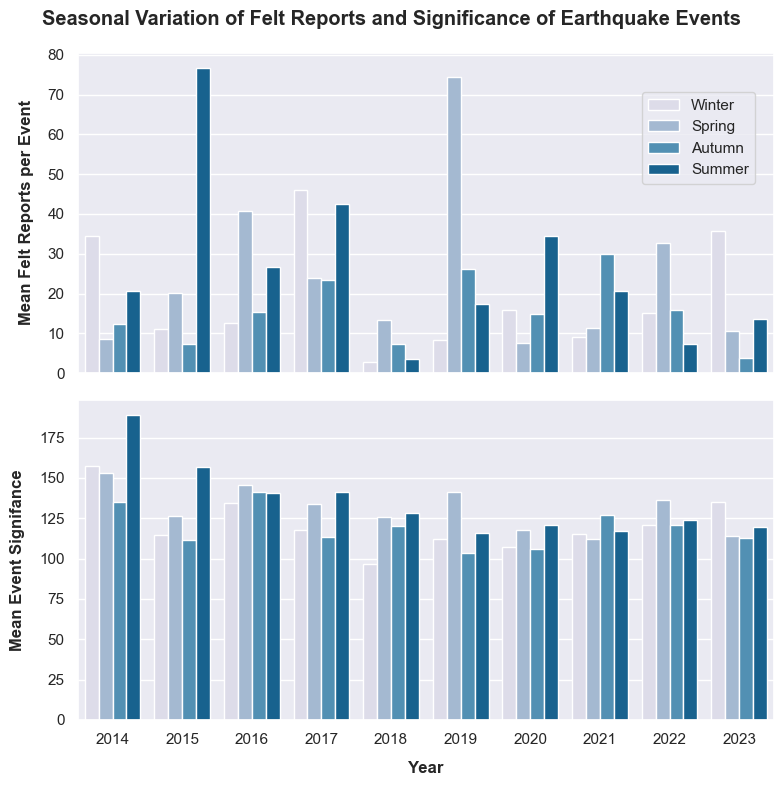

In [32]:
# Set figure aesthetic and arrangement.

sns.set_style("darkgrid")
figs, (ax1, ax2) = plt.subplots(2, 1, figsize = (8, 8))
plt.suptitle("Seasonal Variation of Felt Reports and Significance of Earthquake Events", fontweight = "bold")

# Create first plot of mean number felt reports per year divided by season.

sns.barplot(data = df.sort_values("Year"), errorbar = None, x = "Year", y = "Felt", hue = "Season", palette = "PuBu", ax = ax1) # Ensure sorting by year.
ax1.set_xlabel("") # Shared x axis with second plot.
ax1.set_xticks([]) # Shared x axis with second plot.
ax1.set_ylabel("Mean Felt Reports per Event", labelpad = 10, fontweight = "bold")
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 0.9)) # Shared legend.

# Create second plot of mean significance of earthquake events per year divided by season.

sns.barplot(data = df.sort_values("Year"), errorbar = None, x = "Year", y = "Sig", hue = "Season", palette = "PuBu", ax =  ax2) # Ensure sorting by year.
ax2.set_xlabel("Year", labelpad = 10, fontweight = "bold")
ax2.set_ylabel("Mean Event Signifance", labelpad = 10, fontweight = "bold")
ax2.legend().set_visible(False) # Second legend not necessary.

plt.tight_layout() 
plt.show()

These bar charts indicate that the least amount of felt reports were made per event in winter 2018, corresponding with the lowest seasonal mean event significance. Summer 2014 was the season in which the most felt reports were made per event while summer 2015 had the highest mean event significance. 


#### The distribution of earthquakes over time can be visualised on a map.

In order to view data on a map, a basemap for Hawaii must be retrieved using GeoPandas. 
The 2019 US states shapefile will be accessed from the *US Census Bureau*, and polygons for Hawaii will be extracted by filtering the data. Since the state shapefiles have a different cooridinate reference system to the earthquake dataset, it will be reprojected from NAD83 (EPSG: 4269) to WGS1984 (EPSG: 4326). 


In [33]:
# Access USA states shapefile

states_url = "https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_state_20m.zip"
states = gpd.read_file(states_url)


# View the header of the data

states.head(3)

# Filter the data for the shapefile of Hawaii. 

hawaii = states[states["STATEFP"] == "15"]

# The earthquake coordinates have a CRS of WGS84, so the shapefile for Hawaii needs to be reprojected.

hawaii = hawaii.to_crs(epsg = 4326)

A scatterplot containing coordinate data from the earthquake dataset can placed on top of the basemap to add context to the data.

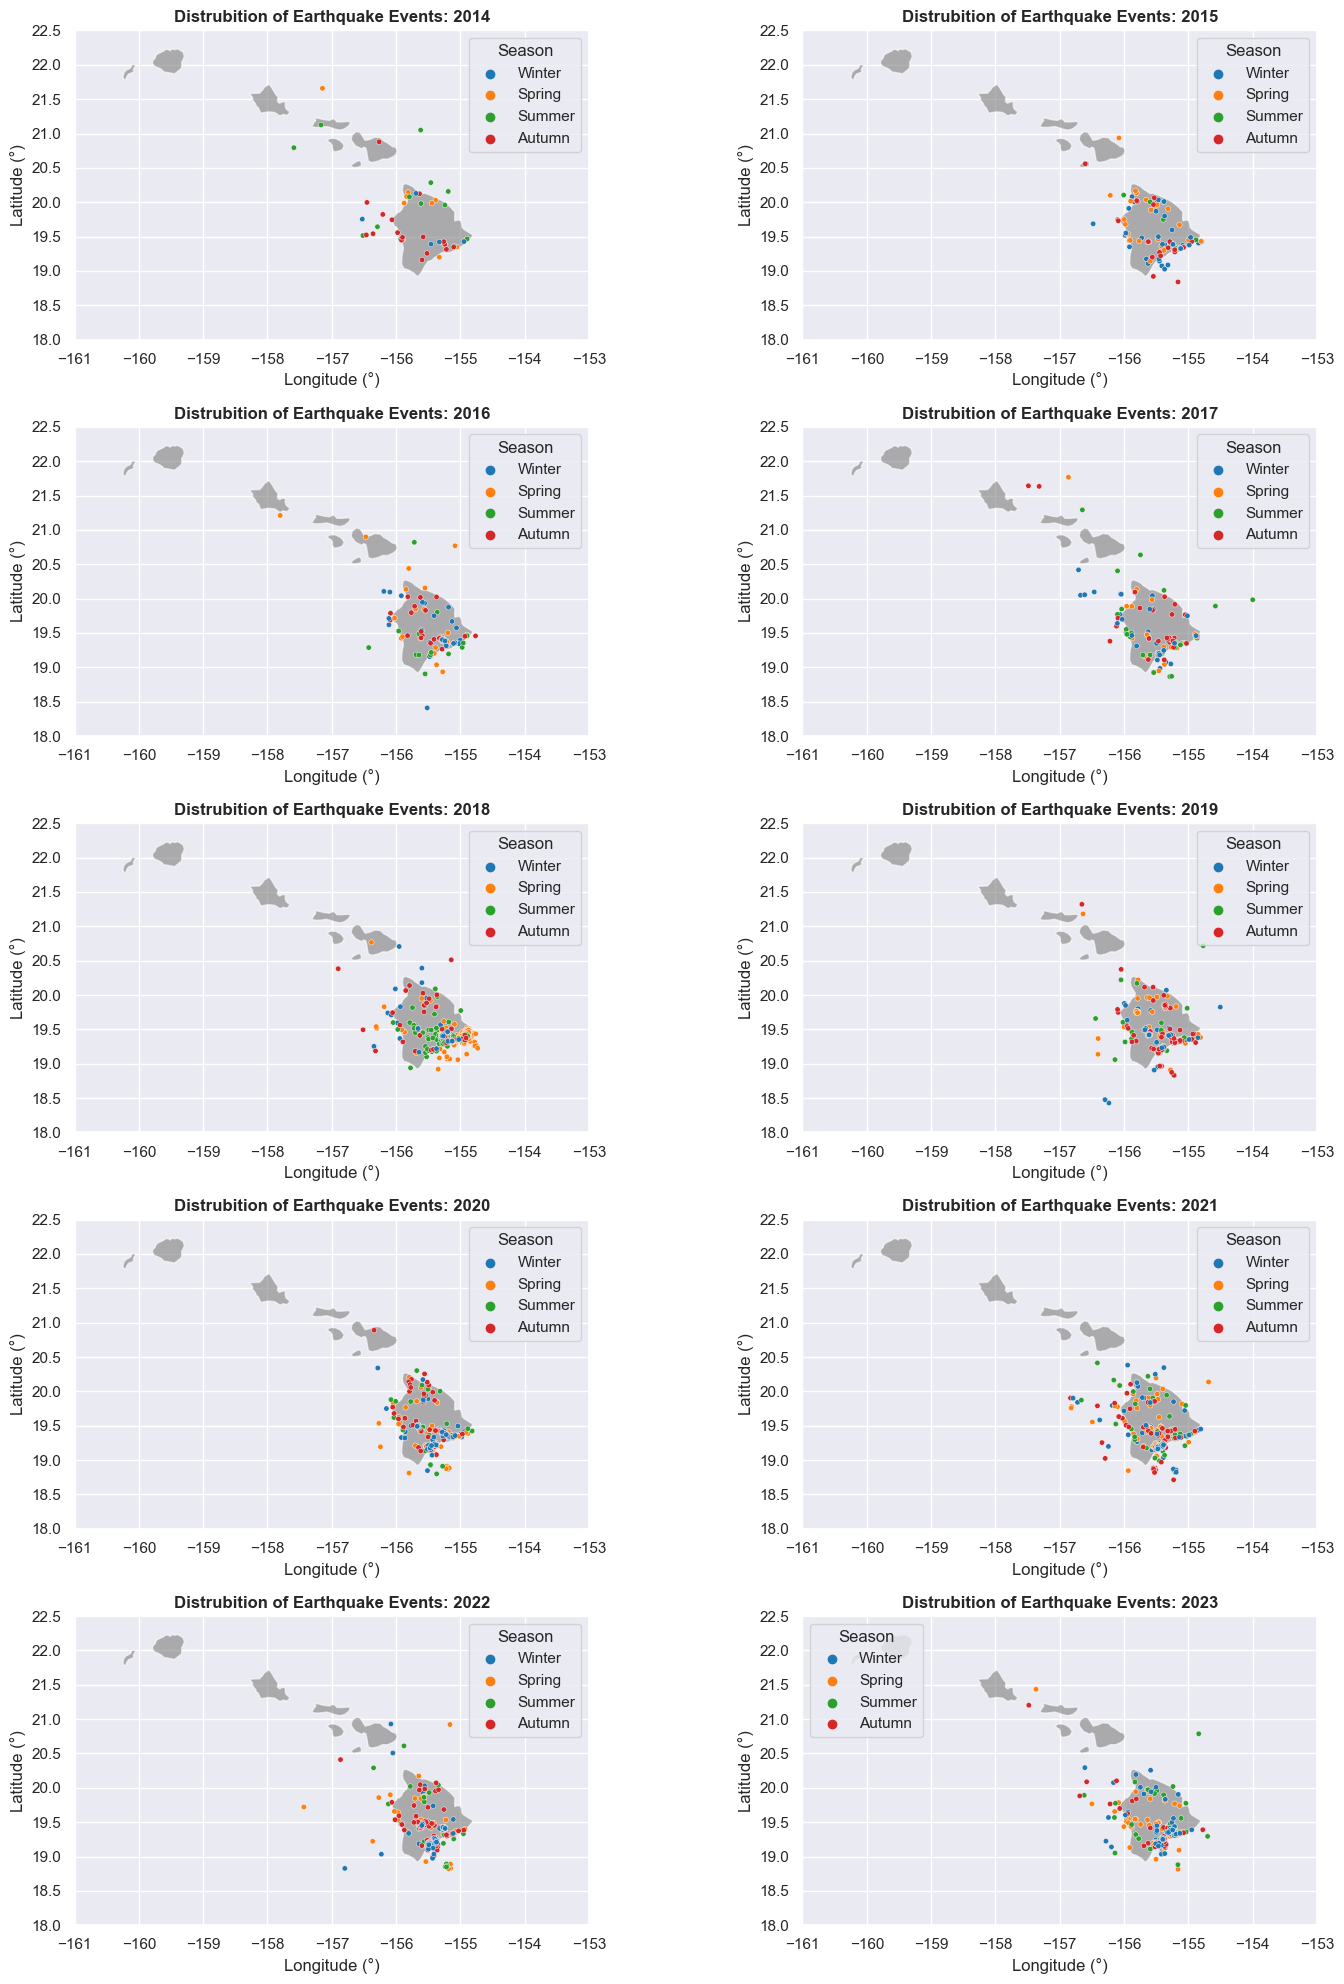

In [34]:
# Set figure aesthetic and arrangement.

sns.set_style("darkgrid") 
plt.figure(figsize=(15, 20))

# Iterate over the unique year values in the sorted dataset and create a scatterplot of coordinates that overlays a basemap.

for i, year in enumerate(sorted(df["Year"].unique())):

    plt.subplot(5, 2, i + 1)   
    hawaii.plot(ax = plt.gca(), alpha = 0.6, color = 'gray') # Add basemap to each plot.
    sns.scatterplot(data = df[df["Year"] == year], x = "Longitude (°)", y = "Latitude (°)", hue = "Season", marker = "o", s = 15, palette = "tab10")
    plt.xlim(-161, -153) # Add limits to x and y axes to ensure consistent aspect ratio between plots.
    plt.ylim(18, 22.5)

    plt.title("Distrubition of Earthquake Events: %s" % year, fontweight = "bold") # Title varies with year.
    
    
plt.tight_layout()
plt.show()

These maps aid the visualisation of the spatial distribution of earthquake events in Hawaii over time. Overall, the majority of data entries are for earthquake events in or around the main island of Hawaii.

### Determining clusters

Geographical information can appear in clusters. Analysis of spatial autocorrelation between earthquake coordinates should be the precursor to any cluster analysis. However, for the purpose of this project, it is assumed that the locations of earthquakes are spatially autocorrelated. Thus, geographical clusters will be determined using the unsupervised K-means method.

In [35]:
# Define a function that takes 2 parameters (input data and a maximum number of clusters)

def k_means(data, max_k = 10):
    means = [] # Empty list for storing the number of clusters
    inertias = [] # Empty list for storing the sum of squared distances between data points
    
# Create a loop that iterates through a number of clusters (K), creating associated inertia for each k value.  
   
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters = k, n_init = 15)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

# Plot the K values against inertia for identification of the optimal number of clusters using the elbow method. 
 
    fig = plt.subplots(figsize=(6, 5))
    sns.lineplot(y = inertias, x = means, color = "darkslateblue")
    plt.title("Testing for Optimal Number of Cluster", fontweight = "bold", y = 1.025)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)    

Once the function has been defined, the earthquake coordinate data can be passed through it to produce a plot from which the optimal number of clusters can be determined. 

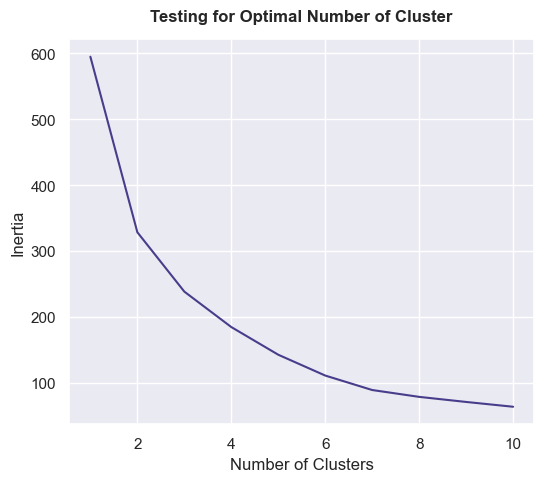

In [36]:
 # Assign the coordinate data to a new variable.

coords = df[["Latitude (°)", "Longitude (°)"]]

# Run the function through the coordinate variable and test for up to 15 clusters.

k_means(coords, 11)

Using the elbow method, the optimal number of clusters appears to be 7. Next, a K-means model will be created and fit to the dataset based on the coordinate data.

In [37]:
# Create a k-means model with 7 clusters.

kmeans = KMeans(n_clusters = 7, n_init = 10, random_state = 32) # Cluster labels are arbitrary so to ensure the clusters are labelled consistently across runs
                                                                # and align with discussions provided in markdown cells, an int is assigned to random_state

# Fit the K-means model to the coordinate data.

kmeans.fit(coords)

# Assign clusters to the earthquake data. 

df["Cluster"] = kmeans.labels_ + 1 # The additional 1 creates labels starting at 1 - 7.

The grouping of data can be visualised by plotting the coordinate data on a scatterplot and classifying the points by cluster.

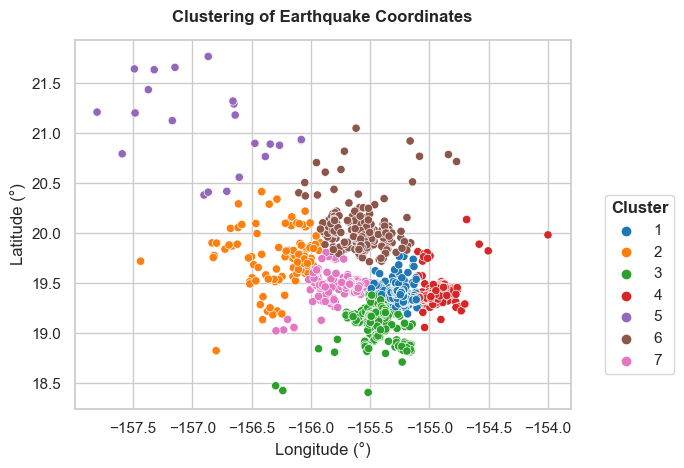

In [38]:
# Set figure aesthetics.

sns.set_style("whitegrid")

# Create scatterplot 

sns.scatterplot(data = df, x = "Longitude (°)", y = "Latitude (°)", hue = "Cluster", palette = "tab10")
legend = plt.legend(bbox_to_anchor = (1.225, 0.6), loc = "upper right", title = "Cluster")
plt.setp(legend.get_title(), fontweight = "bold")
legend._legend_box.align = "left"

plt.title("Clustering of Earthquake Coordinates", fontweight = "bold", y = 1.025)
plt.show()

Although this visulisation provides some insight into the distribution of earthquakes in Hawaii, it is good to view this data on a map to provide some geographical context. 

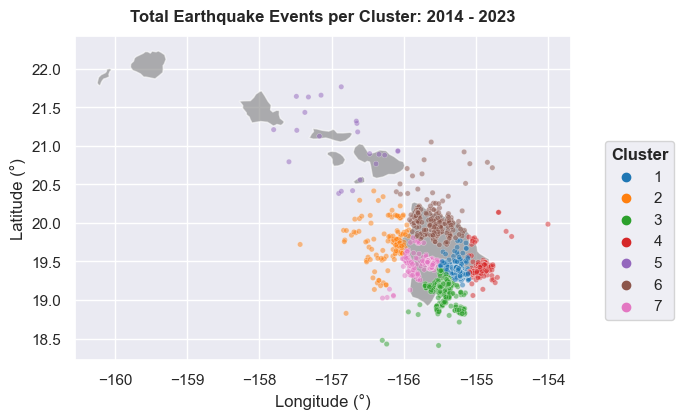

In [39]:
# Set figure aesthetics.

sns.set_style("darkgrid")

# Create Hawaii basemap.

hawaii.plot(ax=plt.gca(), alpha=0.6, color='gray')

# Create scatterplot of earthquakes classified by cluster.

sns.scatterplot(data = df, x = "Longitude (°)", y = "Latitude (°)", hue = "Cluster", marker = "o", alpha = 0.5, s = 15, palette = "tab10")

legend = plt.legend(bbox_to_anchor=(1.225, 0.7), loc='upper right', title = "Cluster")
plt.setp(legend.get_title(), fontweight = "bold")
legend._legend_box.align = "left"

plt.title("Total Earthquake Events per Cluster: 2014 - 2023", y = 1.02, fontweight = "bold")
plt.show()

This map shows that most records of earthquake events in the dataset occur on the main island of Hawaii. As the data has been filtered to only include earthquakes that have been felt by people, a potential reason for this could be the population density on the main island means the likelihood of at least one person feeling an earthquake is higher than on the smaller islands. Without understanding the geological dynamics of islands, it is difficult to offer additonal insights. Further data could be implemented to expand this spatial analysis. 

### Comparing variables between clusters

Data can be grouped by clusters to allow for comparison of data between clusters.

In [40]:
# Group the data by clusters.

cluster_group = df.groupby("Cluster")

# Create a cluster group that contains only numerical data.

cluster_group_num = df.set_index("Cluster").select_dtypes(include = "number").groupby("Cluster")

Mean values of the numerical data can be plotted in bar charts for quick visual comparison of differences between clusters

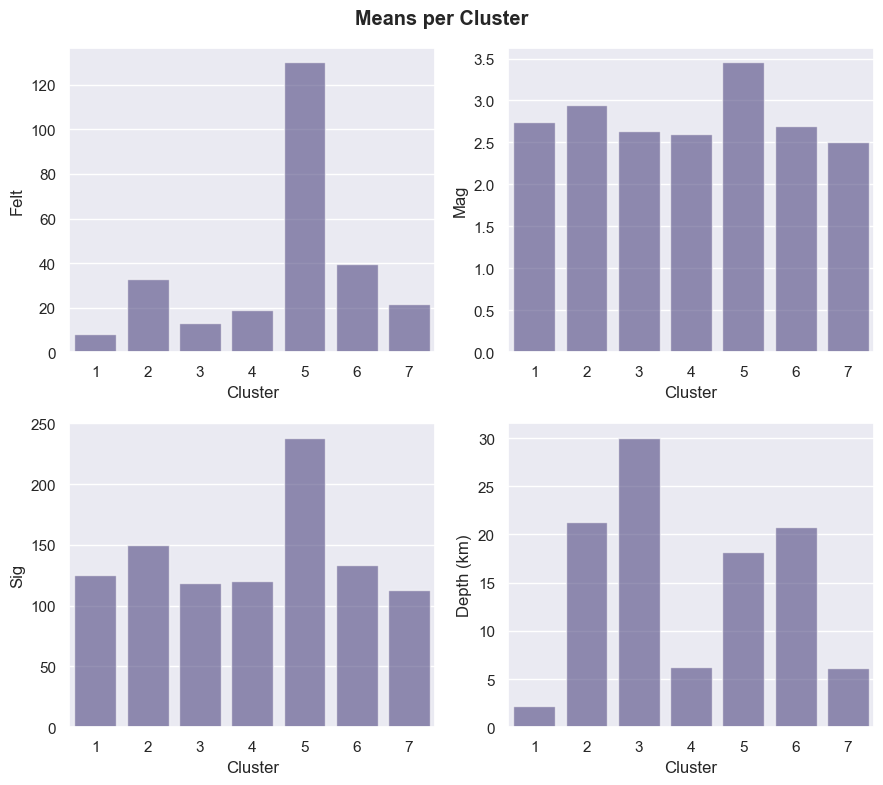

In [41]:
plt.figure(figsize=(9, 8))
plt.suptitle("Means per Cluster", fontweight = "bold")

data = cluster_group_num.mean().drop(columns= ["Nst", "Longitude (°)", "Latitude (°)"])
sns.set()
sns.set_style("darkgrid")
for i, col in enumerate(data):
    plt.subplot(2, 2, i + 1) 
    sns.barplot(data = data, y = col, x = data.index, color = "darkslateblue", alpha = 0.6)  
    

plt.tight_layout()
plt.show()

*Cluster 5* has the a much higher mean number of felt reports and significance value compared to the other clusters. Mean magnitude is considerably uniform amongst clusters. Depth appears to vary the most between clusters.   

In [42]:
# Create a table of relevant means.

cluster_means = cluster_group_num.mean().drop(columns = ["Longitude (°)", "Latitude (°)", "Nst"])
print("Means per cluster:")
cluster_means

Means per cluster:


,Felt,Mag,Sig,Depth (km)
Cluster,,,,
1,7.952936,2.748767,125.316450,2.237281
2,33.017094,2.946667,149.905983,21.283299
3,13.313123,2.641894,118.831395,30.056480
4,19.044379,2.599320,120.144970,6.261414
5,130.045455,3.452727,238.454545,18.156636
6,39.531915,2.695021,133.804255,20.737281
7,21.718543,2.507947,112.602649,6.108295


*Cluster 5* lies the furthest away from the main island and experiences earthquakes with the highest mean signifance (238.45), magnitude (3.45) and felt reports (130.04). The cluster with the lowest mean felt reports (7.95) was *Cluster 1*, while the cluster with the lowest mean significance (112.60) and lowest mean magnitude (2.51) was *Cluster 7*. 
*Cluster 1* exhibits the shallowest earthquakes, with a mean depth of just 2.24km, while *Cluster 3* exhibits the deepest earthquakes with a mean depth of 30.06km.

### Analysing correlation between clusters

The relationship between clusters will be analysed next. Correlation of the mean, maximum and minimum values between the variables *Mag*, *Felt*, *Sig* and *Depth (km)* across clusters will be calculated and plotted on a heatmap.

In [43]:
# Create a new dataframe, df_num, that holds only numeric vairables including the new Cluster variable.

df_num = df.select_dtypes(include = "number")

# Group that dataframe by clusters. 

cluster_nums = df_num.groupby("Cluster")

# Create tables of mean, minimum and maximum values of the numerical values for each cluster.

cluster_means = cluster_nums.mean().drop(columns = ["Longitude (°)", "Latitude (°)", "Nst"]).transpose()

cluster_max = cluster_nums.max().drop(columns = ["Longitude (°)", "Latitude (°)", "Nst"]).transpose()

cluster_min = cluster_nums.min().drop(columns = ["Longitude (°)", "Latitude (°)", "Nst"]).transpose()

# Compute Pearson's correlation coefficient for mean, max and min values between clusters.

mean_corr = cluster_means.corr()

max_corr = cluster_max.corr()

min_corr = cluster_max.corr()

The new variables *mean_corr*, *max_corr* and *min_corr* produce coefficient matrices that will be visualised on heatmaps to allow for easier intrepration of results than their tabulated matrix form.


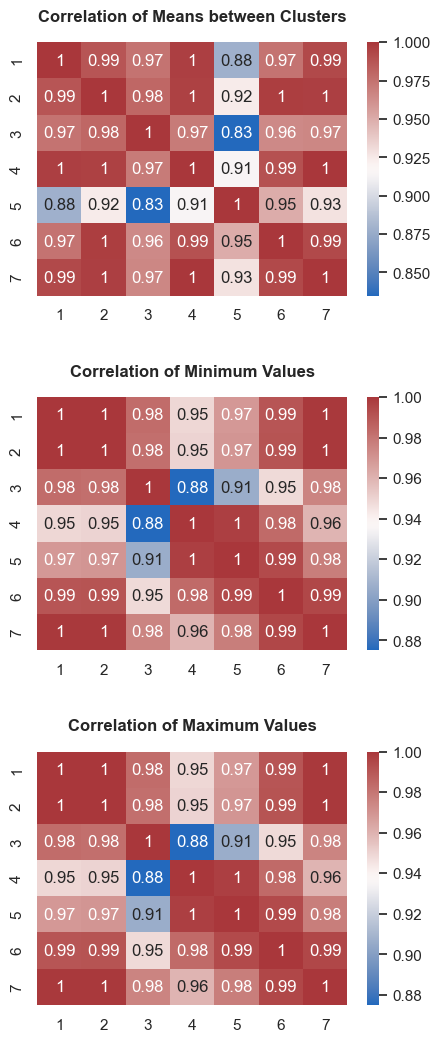

In [44]:
# Create heatmaps that visualise the correlation between mean, maximum and minimum values between clusters. 

# Set figure arrangement. 

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (5, 12.5))

# Visualise the correlation of means in plot 1 

sns.heatmap(mean_corr, annot=True, cmap = "vlag", ax = ax1)
ax1.set_title("Correlation of Means between Clusters", fontweight = "bold", y = 1.05)
ax1.set_xlabel("") # Turn off axis labels 
ax1.set_ylabel("")


sns.heatmap(min_corr, annot=True, cmap = "vlag", ax = ax2)
ax2.set_title("Correlation of Minimum Values", fontweight = "bold", y = 1.05)
ax2.set_xlabel("")
ax2.set_ylabel("")

sns.heatmap(max_corr, annot=True, cmap = "vlag", ax = ax3)
ax3.set_title("Correlation of Maximum Values", fontweight = "bold", y = 1.05)
ax3.set_xlabel("")
ax3.set_ylabel("")


plt.subplots_adjust(hspace = 0.4)
plt.show()

All clusters exhibit strong positive correlation between their summary statistics.


However, most interesting is the correlation of mean values shown in the first heatmap. Although still strong and positive, the mean values in *Cluster 5* are more dissimilar to all other clusters than the pairwise relationship between any other clusters. Whereas *Clusters 2* and *4* are most similar to other clusters.

### Analysing the effects of neighbouring clusters

It seems like clusters closer together exhibit more similarities than clusters further apart. To test this theory, the centroid of each cluster will represents the point location of each cluster, the Euclidean distance between each cluster will be calculated a heatmap will aid the visualisation of distances between clusters. The distance between clusters and their nearest neighbour will be extracted to add additional insights into their spatial distribution. Finally, the distance separating clusters will be correlated to the relationship of means among clusters.

In [45]:
# Find centroids of the clusters using mean values of each cluster's coordinates.

long = cluster_group["Longitude (°)"].mean()
lat = cluster_group["Latitude (°)"].mean()

# Create a table for the centroid coordinates.

cluster_centroids = pd.concat([long, lat], axis = 1)

# View the table of coordinates.

print("Table of cluster centroid coordinates:")
cluster_centroids.transpose()

Table of cluster centroid coordinates:


Cluster,1,2,3,4,5,6,7
Longitude (°),-155.265126,-156.243815,-155.438358,-154.937773,-156.858220,-155.569680,-155.738891
Latitude (°),19.401127,19.753355,19.179163,19.421789,21.060485,20.011799,19.473942


The centroids can be visualised on a map.

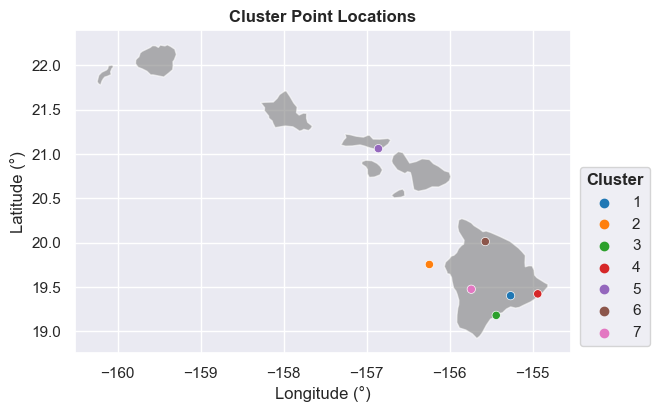

In [46]:
# Create Hawaii basemap.

hawaii.plot(ax=plt.gca(), alpha=0.6, color='gray')

# Overlay the coordinate data on the map.

sns.scatterplot(data = cluster_centroids, x = "Longitude (°)", y = "Latitude (°)", hue = "Cluster", palette = "tab10")
legend = plt.legend(bbox_to_anchor=(1.175, 0.6), loc='upper right', title = "Cluster")
plt.setp(legend.get_title(), fontweight = "bold")

plt.title("Cluster Point Locations", fontweight = "bold")
plt.show()

Euclidean distances between the cluster point locations can be computed using the function *euclidean_distances* and the results can be displayed on a heatmap.

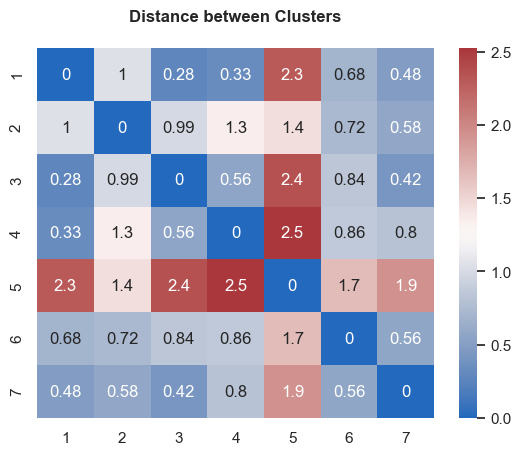

In [47]:
# Compute an array of Euclidean distances between cluster midpoints.

euc_dist = euclidean_distances(cluster_centroids)

# Create a heatmap to visualise the euclidean distance between cluster centroids. 

euc_heat = sns.heatmap(euc_dist, annot=True, cmap="vlag")

# Since the values are based on the array index, the tick labels must be reassigned to correspond with the cluster grouping.

plt.title("Distance between Clusters", fontweight = "bold", y = 1.05)
euc_heat.set_xticklabels(np.arange(1, 8)) 
euc_heat.set_yticklabels(np.arange(1, 8))

plt.show()

This heatmap highlights that *Cluster 5* is the furthest cluster from all others. Its nearest neighbour is *Cluster 2* with a distance of 1.4 degrees.

In [48]:
# Remove the distance between a centroid and itself from the array.

distance =  np.array([row[row != 0] for row in euc_dist])

# Find the distance of the nearest neighbour to each cluster.

min_dist = distance.min(axis=1)

for i, dist in enumerate(min_dist): 
    print("Distance to nearest neighbour of Cluster %s: %.2f degrees." %  (i + 1, dist))

Distance to nearest neighbour of Cluster 1: 0.28 degrees.
Distance to nearest neighbour of Cluster 2: 0.58 degrees.
Distance to nearest neighbour of Cluster 3: 0.28 degrees.
Distance to nearest neighbour of Cluster 4: 0.33 degrees.
Distance to nearest neighbour of Cluster 5: 1.44 degrees.
Distance to nearest neighbour of Cluster 6: 0.56 degrees.
Distance to nearest neighbour of Cluster 7: 0.42 degrees.


Excluding *Cluster 5*, every clusters' nearest neighbour is less than 1 degree away.

Next, Pearson's correlation coefficient will be calculated to determine if the similarities of means between clusters is correlated to Euclidean distances between clusters.

In [49]:
# Convert the values from the mean correlation table to a flattened array.

mc_flat = mean_corr.values.flatten()

# Flatten the Euclidean distances. 

euc_flat = euc_dist.flatten()

# Calculate Pearson's correlation coefficient 

correlation = np.corrcoef(mc_flat, euc_flat)[0,1]

print("Pearson's correlation coefficient is %.2f." % correlation)

Pearson's correlation coefficient is -0.84.


A value -0.84 indicates a strong negative relationship between the distance separating clusters and the relationship of variable means among clusters. This suggests that as distance between clusters increases, the similarity of *Mag*, *Sig*, *Felt* and *Depth (km)* between clusters decreases. In other words, it supports the theory that earthquakes that occur closer together exhibit more similarities than those further apart. 

## Task 3: Discussion

### Key findings

Exploratory analysis summarised the data and provided insight into the distribution of different earthquake conditions and effects. The number of earthquakes and their characteristics are non-uniform over time. Between 2014 and 2023 the season with the largest record of earthquake events was summer, with the highest proportion occurring in July. 43.81% of events occurred in 2018. The highest recorded magnitude during the ten years was 6.9. 

A strong, positive relationship was found between the significance and felt reporting of an event, as well as between the significance and magnitude of an event. The significance of an event is determined using various earthquake characteristics, including felt reporting and magnitude, so this was expected.

Felt reporting was highly variable and was not correlated with any other earthquake characteristic besides significance, suggesting that it may influenced by conditions not described in the dataset.

Most recorded earthquakes occurred on or near the main island of Hawai'i. Analysis of earthquake clusters revealed that earthquakes that occurred closer together were more similar than earthquakes that occurred farther apart. The cluster of earthquakes that occurred farthest from the main island had the highest recorded mean magnitude, significance and number of felt records, however, it contained the lowest number of events. 

There was a positive correlation between the number of stations used to determine earthquake location and earthquake depth. A possible explanation for this is that the deeper the source of the earthquake, the more challenging it is for stations to locate it. However, further analysis would be needed to make any definitive conclusions.


### Challenges and further analysis

Data retrieval from the API was straightforward, though there was a large number of variables associated with earthquakes that were not necessary for the analysis. Although the [documentation](https://earthquake.usgs.gov/data/comcat/) provided by the USGS was helpful, selecting the features to analyse remained challenging. Avoiding data redundancy and irrelevancy was important when filtering the dataset. Unfortunately, as a measure that considered both felt reports and magnitude, using significance values may have introduced collinearity in the analysis and influenced the outcomes. Variable selection should be more carefully considered in future projects to avoid this. 

The scope could be expanded for further analysis to include data across a greater temporal and geographical scale. Additionally, all earthquake records, not just those with felt reports, should be assessed to gain a deeper understanding of which conditions influence the likelihood of an earthquake event impacting humans. To do so would necessitate multiple data retrievals because the API service limits the response data to 20,000 entries. Introducing demographic, geological and spatial data (e.g. tectonic information and volcano locations) could provide additional context to these findings. 

Further research should introduce regression analysis to better understand the relationship between earthquake conditions and their effects. Moreover, geographical statistics, such as spatial autocorrelation, should be determined when drawing insights from earthquake event data due to inherent spatial dependencies. 